# [Hands-On] Understanding GAN and Implementation

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

This lecture is part of the generative model series, specifically focusing on the basic implementation of Generative Adversarial Networks (GANs) for generating digit images similar to those in the MNIST dataset.

## What is a Generative Adversarial Network (GAN)?
A GAN is a type of artificial neural network used to generate new data samples that mimic a given dataset. It consists of two main components: a **Generator** and a **Discriminator**.

The Generator creates fake data samples, while the Discriminator evaluates them against real data samples, determining whether they are real or fake. The two networks are trained simultaneously, with the Generator improving its ability to create realistic data and the Discriminator enhancing its capacity to detect fake data.

### In this Notebook:
We will demonstrate the use of GANs for generating digit images from the MNIST dataset. This notebook provides a comprehensive guide on the fundamental concepts of GANs and their implementation using PyTorch.

### Objectives:
Understand the basic structure and functioning of GANs.
Implement the Generator and Discriminator networks.
Train the GAN on the MNIST dataset to generate digit images.
Visualize the generated images and evaluate the performance of the GAN.
Key Sections:
#### Environment Setup
Ensure the necessary libraries are imported, including PyTorch for model building, torchvision for dataset utilities, and matplotlib for visualization.

#### Generator and Discriminator
Generator Network: Responsible for generating data that mimics real data. It takes a random noise vector as input and outputs an image. The architecture consists of fully connected layers with LeakyReLU activation functions to prevent vanishing gradients during training, and a final Tanh activation function to ensure output values match the normalized MNIST data.  
Discriminator Network: Evaluates the generated data against real data. It determines the probability that a given image is real (from the dataset) or fake (from the Generator).

#### Training the GAN
The training process involves alternating between training the Discriminator and the Generator. The Discriminator learns to distinguish between real and fake images, while the Generator improves its ability to create realistic images.

#### Evaluating and Visualizing Results
After training, we will evaluate the performance of the GAN by visualizing the images generated by the Generator. This section will highlight the strengths and limitations of the basic GAN implementation.

By the end of this lecture, you will have a practical understanding of GANs, including their architecture, implementation, and training process. You will also gain insights into the challenges and considerations involved in generating realistic data with GANs.

Let's dive into the fascinating world of Generative Adversarial Networks!

## Environment Setup
Ensure the necessary libraries are imported. We use PyTorch for building the model, torchvision for dataset utilities, and matplotlib for visualization.


In [1]:
!pip install imageio

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
# Function to set the seed for reproducibility
import random
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

## Dataset Preparation
We will use the MNIST dataset, consisting of handwritten digits, as our training data.


In [4]:
# DataLoader for MNIST
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(28),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5], [0.5])  # Normalize to range [-1, 1]
                   ])),
    batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 524kB/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



## Generator and Discriminator
Below are the PyTorch implementations of the Generator and Discriminator networks. The Generator takes a latent space vector and outputs an image, while the Discriminator takes an image and outputs the probability of it being real.


### Generator Network
The Generator in a GAN is responsible for generating data that is similar to the real data it's trying to mimic. In the case of working with the MNIST dataset, the Generator takes a random noise vector as input and outputs a 28x28 image. The architecture consists of fully connected layers and uses the LeakyReLU activation function to prevent vanishing gradients during training. The final layer uses a Tanh activation function to ensure the output values are between -1 and 1, matching the normalized MNIST data.


In [5]:
class Generator(nn.Module):
    """
    Generator class for GAN.
    Takes a latent vector (size 100) as input and produces an image (size 784, i.e., 28x28) as output.
    Aims to generate fake images indistinguishable from real MNIST digits.
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()  # Outputs in range [-1, 1] to match the preprocessed MNIST images
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)  # Reshape to image dimensions


### Discriminator Network
The Discriminator in a GAN evaluates whether a given image is real (from the MNIST dataset) or fake (generated by the Generator). It consists of fully connected layers that gradually reduce the dimensionality, aiming to classify the input image. The LeakyReLU activation function is used for its non-saturating nature, and a Sigmoid activation at the output layer for binary classification.


In [6]:
class Discriminator(nn.Module):
    """
    Discriminator class for GAN.
    Takes an image (size 784, i.e., 28x28) as input and predicts whether the image is real or generated.
    Outputs a probability value between 0 and 1.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Sigmoid activation to output probabilities
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


## Initialization
Here we initialize the Generator and Discriminator along with their optimizers.


In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


## Training Loop
The training process involves alternating between updating the Discriminator to better distinguish real images from fake ones generated by the Generator, and updating the Generator to produce more realistic images.


In [8]:
# Loss function
criterion = nn.BCELoss()

# Number of epochs
num_epochs = 100

# For visualizing the progress
fixed_noise = torch.randn(64, 100, device=device)

os.makedirs('./images', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        if epoch == 0 and i == 0:
            sample_real_images = real_images # to keep batch_size

        batch_size = real_images.size(0)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator with real images
        discriminator.zero_grad()
        outputs = discriminator(real_images.to(device))
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Train Discriminator with fake images
        noise = torch.randn(batch_size, 100, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize for discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize for generator
        g_loss.backward()
        optimizer_G.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save real images once for comparison
    if epoch == 0:
        save_image(sample_real_images, './images/real_images.png')

    # Save sampled images every epoch
    fake_images = generator(fixed_noise)
    save_image(fake_images, f'./images/fake_images_epoch_{epoch+1:04d}.png')

    # Save discriminator results for each image in the grid
    discriminator_results = discriminator(fake_images).cpu().detach().numpy().reshape(8, 8)
    np.save(f'./results/discriminator_outputs_epoch_{epoch+1:04d}.npy', discriminator_results)

print('Training finished.')


Epoch [1/100], Step [200/938], d_loss: 1.3567, g_loss: 0.4353, D(x): 0.45, D(G(z)): 0.21
Epoch [1/100], Step [400/938], d_loss: 0.5976, g_loss: 4.0959, D(x): 0.93, D(G(z)): 0.37
Epoch [1/100], Step [600/938], d_loss: 0.3819, g_loss: 4.0497, D(x): 0.77, D(G(z)): 0.03
Epoch [1/100], Step [800/938], d_loss: 0.3552, g_loss: 2.7508, D(x): 0.97, D(G(z)): 0.24
Epoch [2/100], Step [200/938], d_loss: 0.3068, g_loss: 3.1996, D(x): 0.91, D(G(z)): 0.16
Epoch [2/100], Step [400/938], d_loss: 0.5440, g_loss: 2.8327, D(x): 0.75, D(G(z)): 0.04
Epoch [2/100], Step [600/938], d_loss: 0.2605, g_loss: 3.4778, D(x): 0.92, D(G(z)): 0.10
Epoch [2/100], Step [800/938], d_loss: 0.2881, g_loss: 2.6277, D(x): 0.89, D(G(z)): 0.09
Epoch [3/100], Step [200/938], d_loss: 0.4540, g_loss: 1.5517, D(x): 0.83, D(G(z)): 0.07
Epoch [3/100], Step [400/938], d_loss: 0.1942, g_loss: 3.0496, D(x): 0.93, D(G(z)): 0.05
Epoch [3/100], Step [600/938], d_loss: 0.2932, g_loss: 2.9784, D(x): 0.93, D(G(z)): 0.15
Epoch [3/100], Step [

### Training Loop Output Explanation

During the training of a Generative Adversarial Network (GAN), we monitor several key metrics to understand the performance and dynamics of the training process. At each significant step, we print out the following information:

- `d_loss`: This represents the loss of the discriminator. It's a measure of how well the discriminator can distinguish between real and fake images. A lower discriminator loss indicates better discriminator performance.

- `g_loss`: This is the loss of the generator. It quantifies how well the generator is doing at creating images that the discriminator classifies as real. A lower generator loss means the generator is producing more convincing images.

- `D(x)`: This score represents the average output of the discriminator when evaluating real images from the dataset. It's a probability value between 0 and 1, where a value closer to 1 indicates that the discriminator is more confident that the images are real.

- `D(G(z))`: This score shows the average output of the discriminator when evaluating fake images generated by the generator. Similar to `D(x)`, it's a probability value. A value closer to 0 indicates that the discriminator can effectively recognize fake images.

### Interpretation:

- **When `D(x)` is high (close to 1)**, it suggests the discriminator is performing well in identifying real images as real.

- **When `D(G(z))` is low (close to 0)**, it indicates the discriminator is good at spotting fake images produced by the generator.

- **Ideal Scenario**: In a well-trained GAN, `D(x)` should be high, and `D(G(z))` should be low, indicating the discriminator can accurately distinguish real from fake. However, the generator should also be improving over time, making `D(G(z))` gradually increase (indicating the fake images are becoming more convincing).

It's important to observe the trends of these metrics over epochs to gauge the training progress and dynamics between the generator and discriminator.

## Results Visualization
After training, we visualize the generated images to evaluate the performance of our GAN.


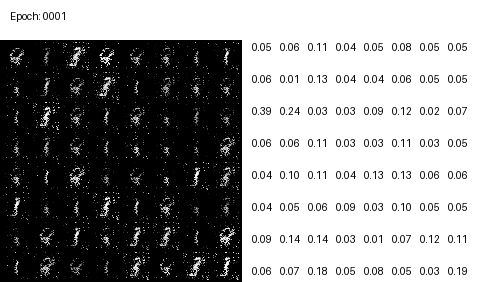

In [9]:
import os
import torch
import imageio
from PIL import Image, ImageDraw, ImageFont
import glob
import numpy as np

def create_gif_with_predictions(image_folder='./images', result_folder='./results', gif_name='CGAN_training_progress.gif', duration=200):
    images = []

    fns = glob.glob(os.path.join(image_folder, 'fake_images_epoch_*.png'))
    filenames = sorted(fns, key=lambda x: int(x.split('_')[-1].split('.')[0]))

    # Load default font
    font = ImageFont.load_default()

    for filename in filenames:
        epoch_number = filename.split('_')[-1].split('.')[0]
        image = Image.open(filename)
        result_filename = f'discriminator_outputs_epoch_{epoch_number}.npy'
        discriminator_outputs = np.load(os.path.join(result_folder, result_filename))

        new_image = Image.new('RGB', (image.width * 2, image.height + 40), 'white')
        new_image.paste(image, (0, 40))

        draw = ImageDraw.Draw(new_image)
        text_x = 10
        text_y = 10
        draw.text((text_x, text_y), f'Epoch: {epoch_number}', fill="black", font=font)

        for idx in range(8):
            for jdx in range(8):
                position = (image.width + 10 + jdx * 28, 40 + idx * 28 + 1 + idx * 4)
                text = f'{discriminator_outputs[idx, jdx]:.2f}'
                if discriminator_outputs[idx, jdx] > 0.5:
                    draw.text(position, text, fill="blue", font=font, stroke_fill="blue")
                else:
                    draw.text(position, text, fill="black", font=font)

        images.append(new_image)

    imageio.mimsave(gif_name, images, duration=duration / 1000.0)
    return gif_name

gif_fn = create_gif_with_predictions()

# Display the created GIF in Jupyter Notebook
from IPython.display import Image as IPImage, display
display(IPImage(filename=gif_fn))


## Conclusion

In this lecture, we delved into the basic implementation of Generative Adversarial Networks (GANs) to generate digit images similar to those in the MNIST dataset. We began by understanding the core components of GANs: the Generator and the Discriminator. The Generator's task is to create realistic images from random noise, while the Discriminator's role is to distinguish between real and fake images.

We implemented both networks using PyTorch, starting with the Generator network, which converts latent vectors into 28x28 images using a series of fully connected layers and activation functions designed to ensure the output mimics the MNIST data distribution. The Discriminator network, on the other hand, was designed to evaluate the authenticity of the images, distinguishing real ones from those generated by the Generator.

The training process involved a careful balance between the two networks. By alternately training the Discriminator to improve its ability to detect fake images and the Generator to produce more realistic images, we achieved a dynamic equilibrium where both networks continually improved.

Throughout the training, we visualized the images generated by the Generator to evaluate the progress and quality of the generated samples. Initially, the generated images were far from realistic, but as training progressed, the Generator produced increasingly convincing digit images.

## Further Exploration
- Implement conditional GANs to generate images of specific classes.
- Explore advanced GAN architectures like CGANs, DCGANs, and StyleGANs.
- Apply GANs to different types of data, such as text or audio.
